In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import auc


# Model evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay,
    
)

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Preprocessing and pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [40]:
#Importing data from huggingface

from datasets import load_dataset

ds = load_dataset("Sri-Vigneshwar-DJ/marketing-leadsprediction")

In [42]:
#Convert to Pandas DataFrame
import pandas as pd
df = ds['train'].to_pandas()
print(df.head())
print(df.info())

  Conversion Data Lead Capture Type Lead Disposition  Lead Source Lead Stage  \
0             YES              None   Not Interested  FB Lead Ads   New Lead   
1            None              None    Not Connected  FB Lead Ads   New Lead   
2            None              None     Disqualified  FB Lead Ads   New Lead   
3             YES              None    Not Connected  FB Lead Ads   New Lead   
4             YES              None    Not Connected  FB Lead Ads   New Lead   

  Registered           State Student Grade     Student Stream  Total Calls  \
0       None       Karantaka           YES  science_with_math         15.0   
1       None             A P           YES               STEM          5.0   
2       None       tamilnadu           YES                COM          3.0   
3       None  Andhra Pradesh        DEGREE               None         36.0   
4       None       Karnataka        DEGREE               None         49.0   

   Total Connects  Lead Number    Created On  
0  

In [43]:
#Check Shape
print(df.shape)

(58972, 13)


In [44]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58972 entries, 0 to 58971
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Conversion Data    27059 non-null  object 
 1   Lead Capture Type  235 non-null    object 
 2   Lead Disposition   52729 non-null  object 
 3   Lead Source        58972 non-null  object 
 4   Lead Stage         58971 non-null  object 
 5   Registered         1478 non-null   object 
 6   State              58902 non-null  object 
 7   Student Grade      57173 non-null  object 
 8   Student Stream     282 non-null    object 
 9   Total Calls        58971 non-null  float64
 10  Total Connects     58970 non-null  float64
 11  Lead Number        58972 non-null  int64  
 12  Created On         58972 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 5.8+ MB
None


In [45]:
#Inspect Missing Values
print(df.isnull().sum())

Conversion Data      31913
Lead Capture Type    58737
Lead Disposition      6243
Lead Source              0
Lead Stage               1
Registered           57494
State                   70
Student Grade         1799
Student Stream       58690
Total Calls              1
Total Connects           2
Lead Number              0
Created On               0
dtype: int64


In [46]:
#identifying unique lead status
print(df['Lead Disposition'].unique())

print(df['Lead Stage'].unique())

['Not Interested' 'Not Connected' 'Disqualified' 'New' None
 'Appointment Fixed' 'Future Lead' 'Demo Conducted' 'Call Later'
 'Applied from different number' 'Language Barrier' 'Non-eligible stream'
 'Applied' 'New - Reactivated' 'Appointment Confirmed'
 'Not Interested - Lead' 'Interested in Webinar' 'Reactivated'
 'Appointment Cancelled' 'RNR' 'Switched Off' 'Wrong Number'
 'Not Interested - Applicant' 'Not Relevant' 'Cold']
['New Lead' None 'Admission Offered' 'Registered' 'Admission Accepted'
 'Elapsed' 'KQ Rejected' 'KQ Selected' 'Interview Not Cleared' 'Applied'
 'KQ Cleared' 'KQ Not Cleared' 'KQ Challenge Completed' 'Payment Done']


In [47]:
#Consolidate similar lead status
def clean_disposition(x):
    if pd.isna(x):
        return "Unknown"
    x = x.lower()
    if "not interested" in x:
        return "Not Interested"
    if "appointment" in x:
        return "Appointment"
    if "demo" in x:
        return "Demo Conducted"
    if "call later" in x or "rnr" in x or "switched off" in x:
        return "Follow-up"
    if "language" in x or "stream" in x or "not eligible" in x:
        return "Not Eligible"
    if "wrong number" in x:
        return "Invalid Contact"
    if "cold" in x:
        return "Cold"
    if "applied" in x:
        return "Applied"
    if "future" in x:
        return "Future Lead"
    if "reactivated" in x:
        return "Reactivated"
    return x.title()

df['Lead Disposition Clean'] = df['Lead Disposition'].apply(clean_disposition)
print(df['Lead Disposition Clean'].value_counts())


Lead Disposition Clean
Not Interested           15761
Disqualified             14931
Not Connected            10421
Unknown                   6243
New                       4252
Future Lead               2352
Demo Conducted            1802
Appointment               1202
Applied                    613
Not Eligible               596
Reactivated                456
Follow-up                  331
Interested In Webinar        4
Invalid Contact              4
Not Relevant                 2
Cold                         2
Name: count, dtype: int64


In [48]:
#simply lead stage data
def group_stage(stage):
    if pd.isna(stage):
        return "Unknown"
    stage = stage.lower()
    if "new" in stage:
        return "New"
    if "applied" in stage:
        return "Applied"
    if "kq" in stage:
        return "Qualification"
    if "interview" in stage:
        return "Interview"
    if "registered" in stage:
        return "Registered"
    if "payment" in stage:
        return "Paid"
    if "admission" in stage:
        return "Admission"
    if "elapsed" in stage:
        return "Dropped"
    return stage.title()

df['Lead Stage Clean'] = df['Lead Stage'].apply(group_stage)
print(df['Lead Stage Clean'].value_counts())


Lead Stage Clean
New              57447
Qualification      489
Dropped            438
Admission          311
Registered         251
Applied             23
Interview            7
Paid                 5
Unknown              1
Name: count, dtype: int64


In [49]:
#rename and binarize Coversion Data 

df['Converted'] = df['Conversion Data'].apply(lambda x: 1 if x == 'YES' else 0)
print(df['Converted'].value_counts(normalize=True))


Converted
0    0.541155
1    0.458845
Name: proportion, dtype: float64


In [50]:
# Drop high-null or irrelevant columns
df.drop(columns=[
    'Lead Number',          
    'Registered',           
    'Lead Capture Type',    
    'Student Stream',
    'Lead Capture Type',       
], axis=1, inplace=True)

print(df.shape)





(58972, 12)


In [51]:
#Convert "Created On" to DateTime and Engineer Time Features
df['Created On'] = pd.to_datetime(df['Created On'], errors='coerce')

# Extract datetime components
df['created_month'] = df['Created On'].dt.month
df['created_day'] = df['Created On'].dt.day
df['created_weekday'] = df['Created On'].dt.dayofweek

# Drop original date column
df = df.drop(columns=['Created On'])

print(df[['created_month', 'created_day', 'created_weekday']].head())


C:\Users\Roche\AppData\Local\Temp\ipykernel_17972\1521991850.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Created On'] = pd.to_datetime(df['Created On'], errors='coerce')


   created_month  created_day  created_weekday
0              4           17                2
1              1            8                0
2              6           15                5
3              6           18                1
4              6           19                2


In [52]:
#Handle Missing Values on numerical columns
# Fill missing with median
df['Total Calls'] = df['Total Calls'].fillna(df['Total Calls'].median())
df['Total Connects'] = df['Total Connects'].fillna(df['Total Connects'].median())


In [53]:
#Handle Missing Values on categorical columns
# Fill missing values in categorical columns with "Unknown"
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna('Unknown')


In [54]:
#Encode Target Variable
df['Converted'] = df['Conversion Data'].apply(lambda x: 1 if x == 'YES' else 0)

# Drop original Conversion Data column
df = df.drop(columns=['Conversion Data'])

# Confirm
print(df['Converted'].value_counts(normalize=True))


Converted
0    0.541155
1    0.458845
Name: proportion, dtype: float64


EDA Section.

This part will cover:
1 Check class balance in the target
2 Univariate analysis of key features
3 Bivariate analysis — features vs. target
4 Correlation analysis (numerical features)

In [123]:
import sys
print(sys.executable)


c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Scripts\python.exe


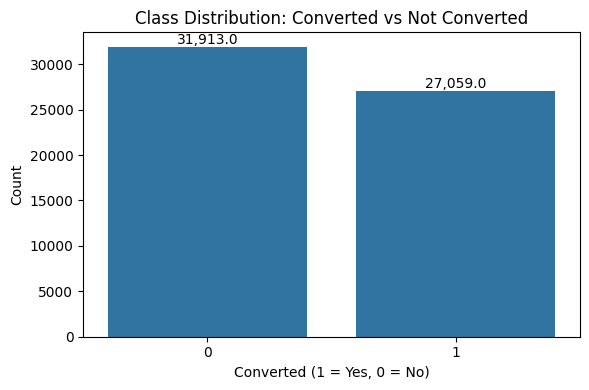

In [36]:


plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Converted')  # Assign the plot to 'ax'
plt.title('Class Distribution: Converted vs Not Converted')
plt.xlabel('Converted (1 = Yes, 0 = No)')
plt.ylabel('Count')

# Add data labels on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,}',               
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


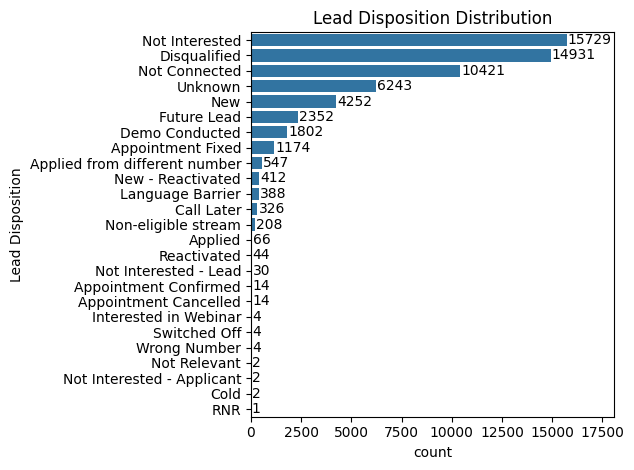

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.countplot(y='Lead Disposition', data=df, order=df['Lead Disposition'].value_counts().index)
plt.title('Lead Disposition Distribution')

# Add labels
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width + 50, y, f'{int(width)}', va='center')

# Expand x-axis limits to fit labels
max_width = max(p.get_width() for p in ax.patches)
ax.set_xlim(0, max_width * 1.15)

plt.tight_layout()
plt.show()


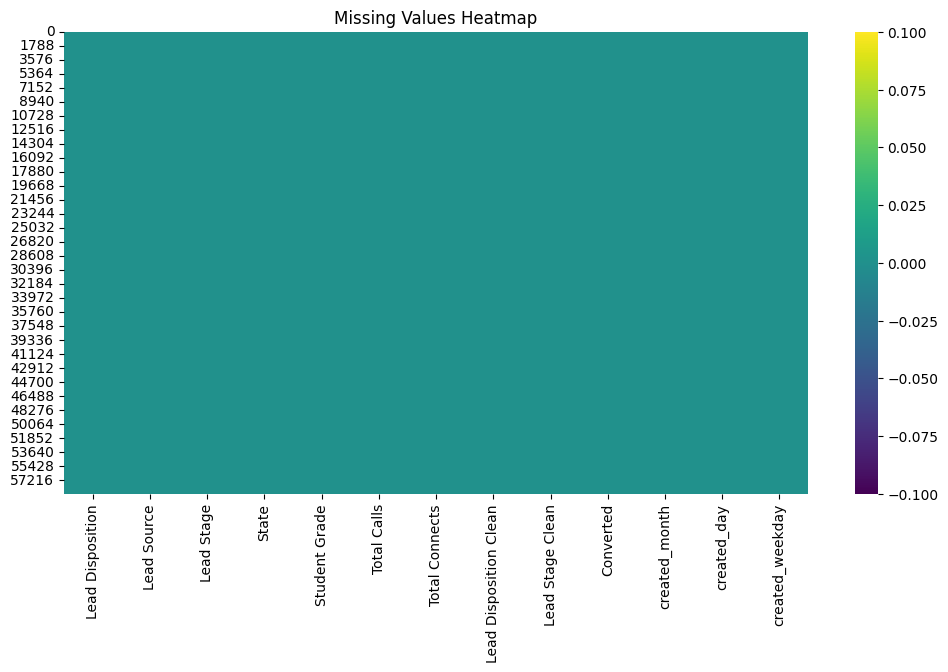

In [37]:
#Check where data is missing to decide how to handle it
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=True, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()


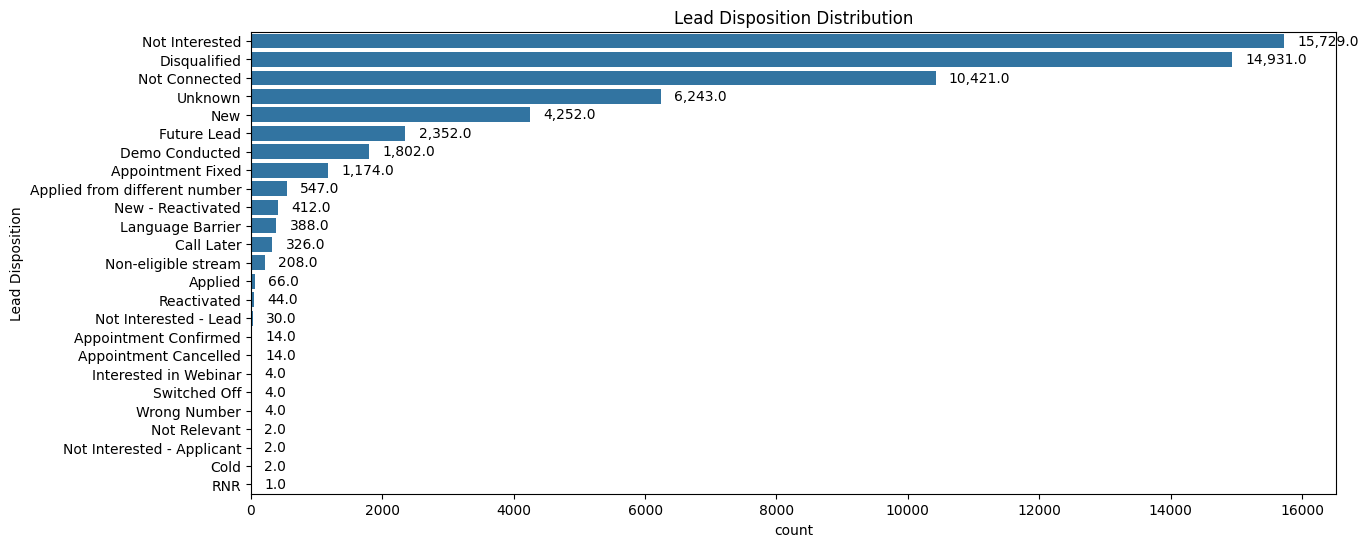

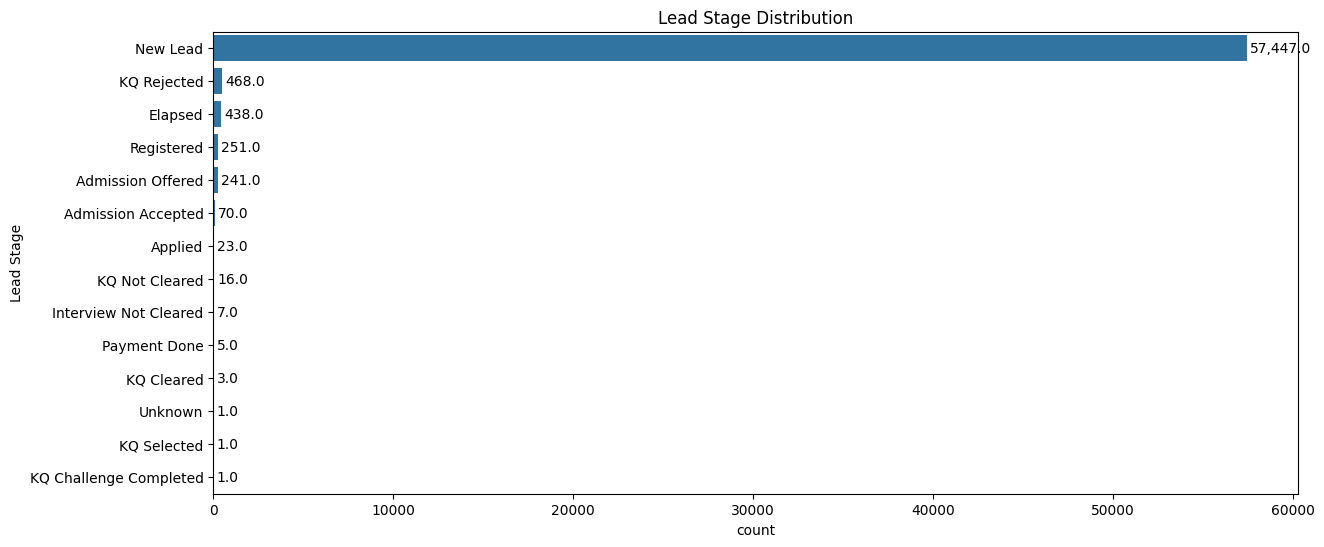

In [55]:
# Lead Disposition Distribution
plt.figure(figsize=(14, 6))
ax1 = sns.countplot(y='Lead Disposition', data=df, order=df['Lead Disposition'].value_counts().index)
plt.title('Lead Disposition Distribution')

# Add data labels
for p in ax1.patches:
    width = p.get_width()
    ax1.annotate(f'{width:,}', 
                 (width + 200, p.get_y() + p.get_height() / 2), 
                 va='center', fontsize=10)

plt.show()

# Lead Stage Distribution
plt.figure(figsize=(14, 6))
ax2 = sns.countplot(y='Lead Stage', data=df, order=df['Lead Stage'].value_counts().index)
plt.title('Lead Stage Distribution')

# Add data labels
for p in ax2.patches:
    width = p.get_width()
    ax2.annotate(f'{width:,}', 
                 (width + 200, p.get_y() + p.get_height() / 2), 
                 va='center', fontsize=10)

plt.show()



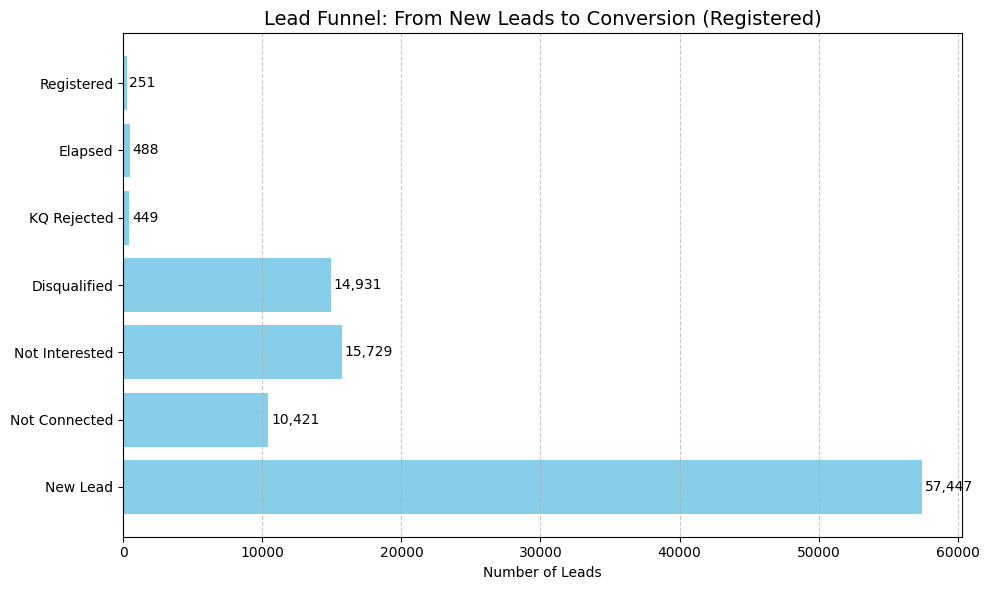

In [56]:
#visual funnel to depict lead transition from different stages

# Define funnel stages and counts based on image data
funnel_stages = [
    'New Lead', 'Not Connected', 'Not Interested', 'Disqualified', 'KQ Rejected', 'Elapsed', 'Registered'
]
lead_counts = [57447, 10421, 15729, 14931, 449, 488, 251]

# Reverse for funnel shape (top to bottom)
funnel_stages = funnel_stages[::-1]
lead_counts = lead_counts[::-1]

# Plotting the funnel
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(funnel_stages, lead_counts, color='skyblue')

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width + 200, bar.get_y() + bar.get_height()/2,
            f'{int(width):,}', va='center')

ax.set_title('Lead Funnel: From New Leads to Conversion (Registered)', fontsize=14)
ax.set_xlabel('Number of Leads')
ax.invert_yaxis()  # Highest stage at the top
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


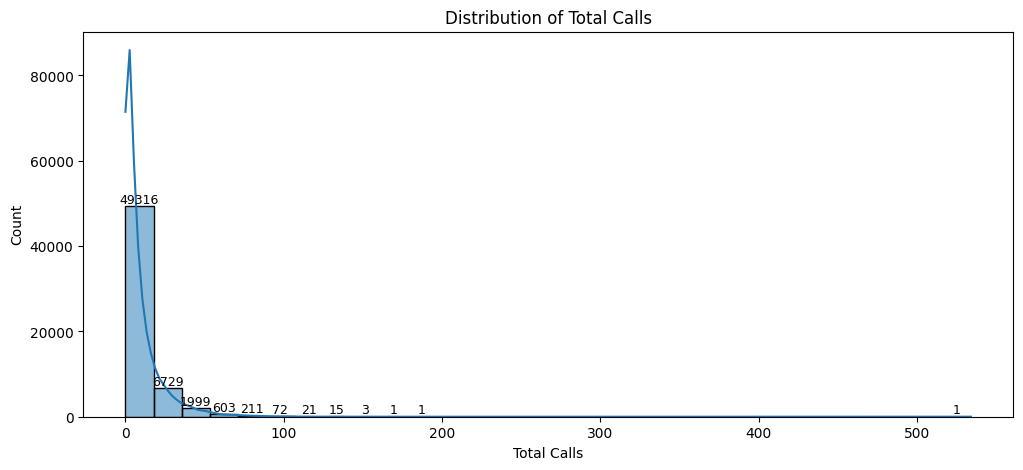

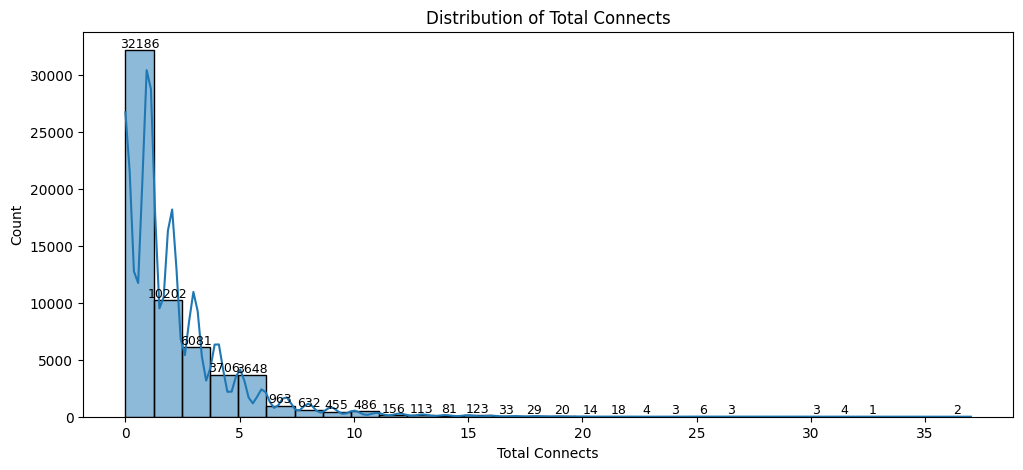

In [57]:

# Plot for Total Calls
plt.figure(figsize=(12,5))
ax1 = sns.histplot(df['Total Calls'], bins=30, kde=True)
plt.title('Distribution of Total Calls')

# Add data labels
for p in ax1.patches:
    height = p.get_height()
    if height > 0:  # Skip empty bins
        ax1.text(p.get_x() + p.get_width()/2, height + 1, int(height), 
                 ha='center', va='bottom', fontsize=9)

plt.show()

# Plot for Total Connects
plt.figure(figsize=(12,5))
ax2 = sns.histplot(df['Total Connects'], bins=30, kde=True)
plt.title('Distribution of Total Connects')

# Add data labels
for p in ax2.patches:
    height = p.get_height()
    if height > 0:
        ax2.text(p.get_x() + p.get_width()/2, height + 1, int(height), 
                 ha='center', va='bottom', fontsize=9)

plt.show()


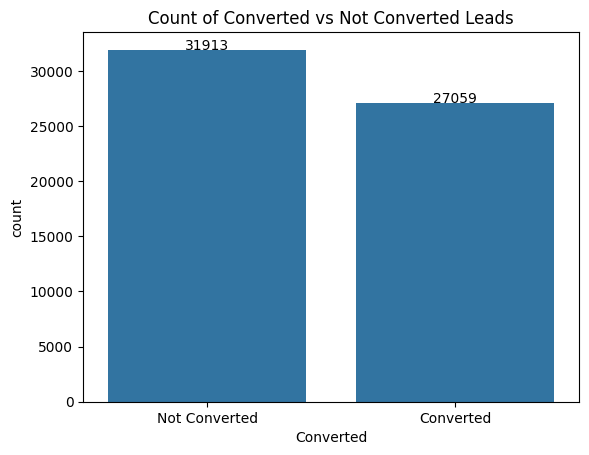

In [58]:

# Plot the countplot
ax = sns.countplot(data=df, x='Converted')
plt.title('Count of Converted vs Not Converted Leads')
plt.xticks([0,1], ['Not Converted', 'Converted'])

# Add data labels
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2., 
        height + 5,                     
        f'{int(height)}',               
        ha="center"                     
    )

plt.show()


C:\Users\Roche\AppData\Local\Temp\ipykernel_17972\843038909.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=conv_by_disposition.values, y=conv_by_disposition.index, palette="viridis", orient='h')


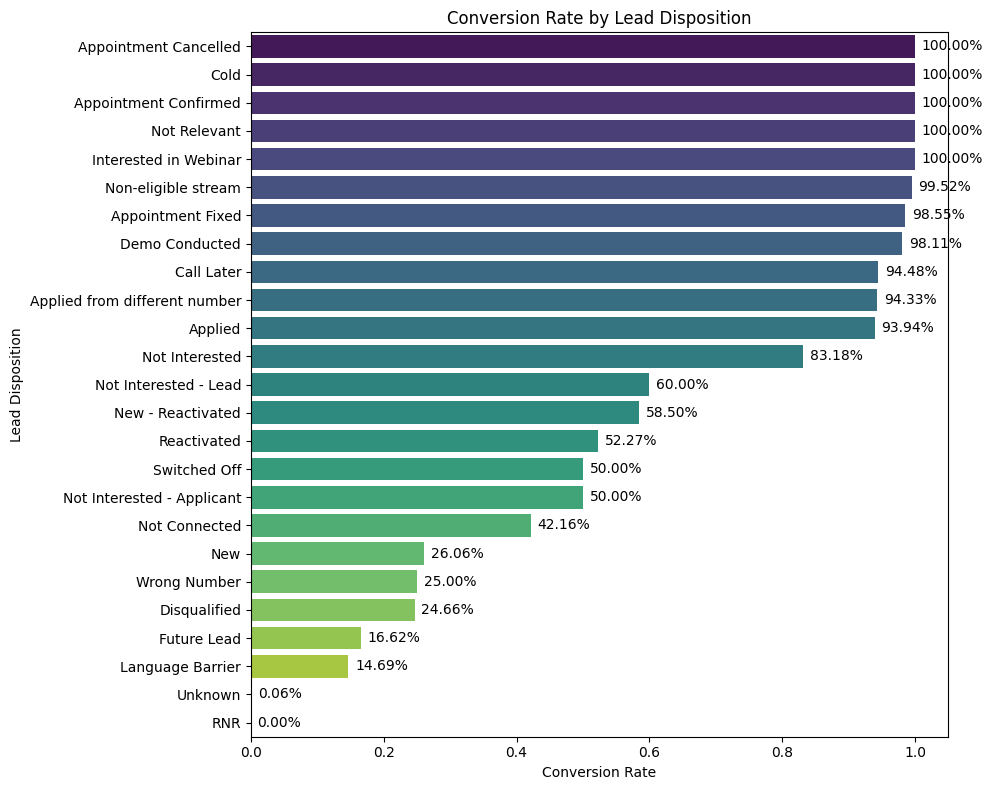

In [63]:

# Calculate conversion rates
conv_by_disposition = df.groupby('Lead Disposition')['Converted'].mean().sort_values(ascending=False)

# print("Conversion Rate by Lead Disposition:")
# print(conv_by_disposition)

# Set figure size and create horizontal barplot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=conv_by_disposition.values, y=conv_by_disposition.index, palette="viridis", orient='h')

# Add percentage labels to the right of each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.01, p.get_y() + p.get_height()/2, f'{width:.2%}', 
            va='center', fontsize=10)

# Axis labels and title
plt.xlabel('Conversion Rate')
plt.ylabel('Lead Disposition')
plt.title('Conversion Rate by Lead Disposition')

# Adjust layout
plt.tight_layout()
plt.show()

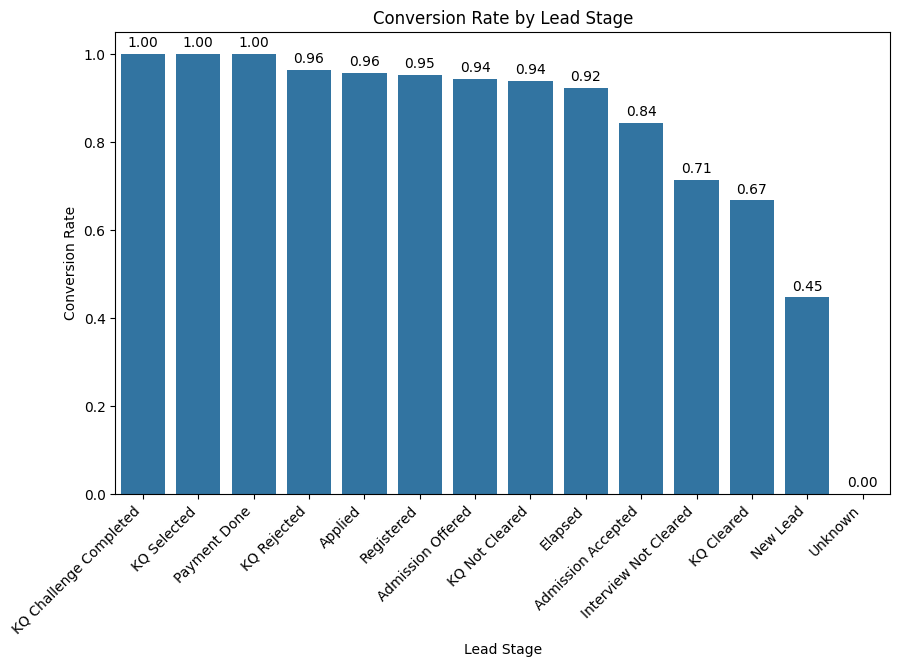

In [69]:
# Conversion Rate by Lead Stage
conv_by_stage = df.groupby('Lead Stage')['Converted'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
ax = sns.barplot(x=conv_by_stage.index, y=conv_by_stage.values)

# Add data labels
for i, v in enumerate(conv_by_stage.values):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Lead Stage')
plt.ylim(0, 1.05)  # Add some padding above bars for labels
plt.show()



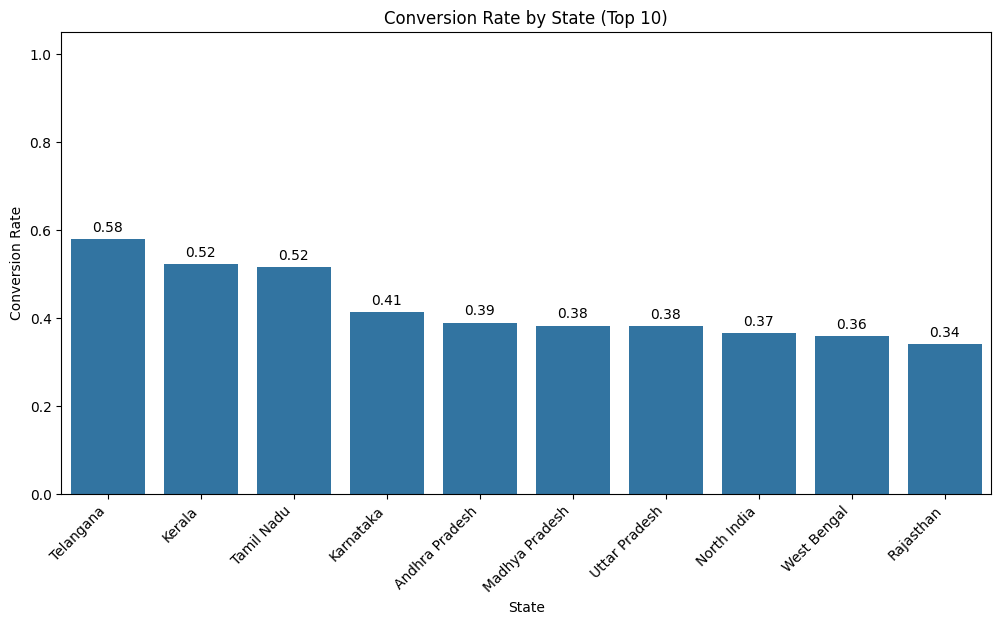

In [68]:

# Top 10 states by lead count
top_states = df['State'].value_counts().head(10).index

# Conversion rate by state (only top states)
conv_by_state = df[df['State'].isin(top_states)].groupby('State')['Converted'].mean().sort_values(ascending=False)

plt.figure(figsize=(12,6))
ax = sns.barplot(x=conv_by_state.index, y=conv_by_state.values)

# Add data labels
for i, v in enumerate(conv_by_state.values):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by State (Top 10)')
plt.ylim(0, 1.05)  # Extend y-axis to make room for labels
plt.show()


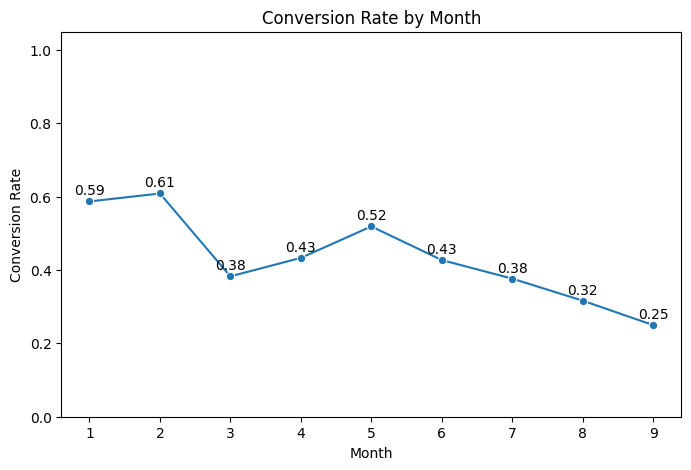

In [70]:
# Conversion Rate over Months
conv_by_month = df.groupby('created_month')['Converted'].mean()

plt.figure(figsize=(8,5))
ax = sns.lineplot(x=conv_by_month.index, y=conv_by_month.values, marker='o')
plt.xlabel('Month')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Month')

# Add data labels to each point
for x, y in zip(conv_by_month.index, conv_by_month.values):
    ax.text(x, y + 0.01, f'{y:.2f}', ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.05)  # Add space above points for labels
plt.show()


Behavioral Metrics

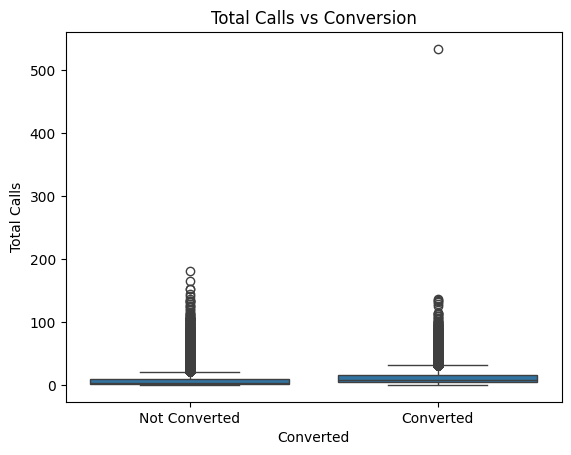

In [ ]:
# Total Calls vs Conversion
#Hypothesis: More calls might correlate with higher conversion rate
sns.boxplot(data=df, x='Converted', y='Total Calls')
plt.xticks([0,1], ['Not Converted', 'Converted'])
plt.title('Total Calls vs Conversion')
plt.show()


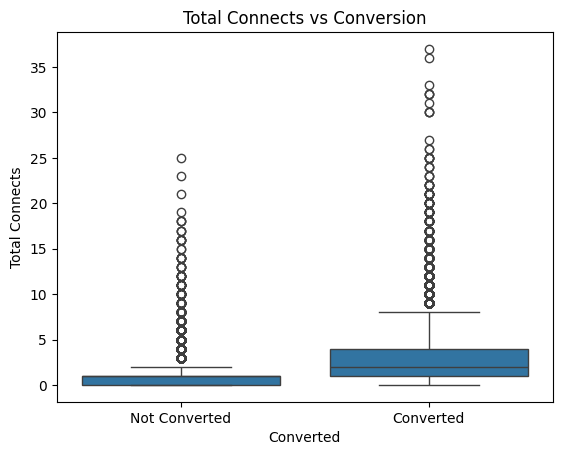

In [ ]:
#Total Connects vs Conversion
#Hypothesis: Leads that were successfully connected with (vs just called) are more likely to convert
sns.boxplot(data=df, x='Converted', y='Total Connects')
plt.xticks([0,1], ['Not Converted', 'Converted'])
plt.title('Total Connects vs Conversion')
plt.show()


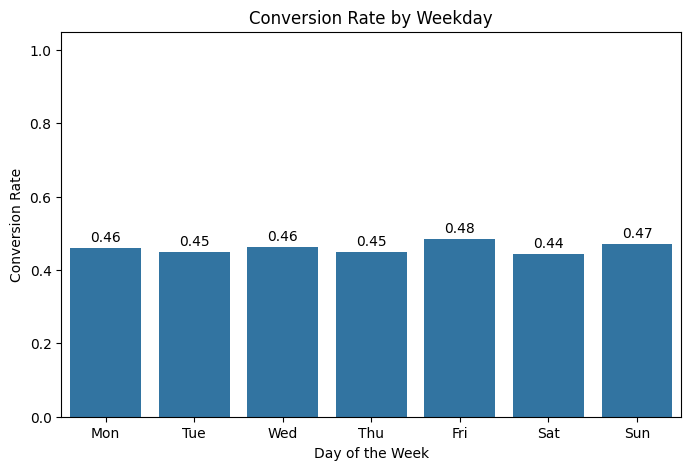

In [71]:
# Map numeric weekdays to names
weekday_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
df['created_weekday_name'] = df['created_weekday'].map(weekday_map)

# Group and reorder weekdays
conv_by_day = df.groupby('created_weekday_name')['Converted'].mean().reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

# Plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x=conv_by_day.index, y=conv_by_day.values)
plt.title('Conversion Rate by Weekday')
plt.ylabel('Conversion Rate')
plt.xlabel('Day of the Week')

# Add data labels
for i, v in enumerate(conv_by_day.values):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

plt.ylim(0, 1.05)  # Add padding for labels
plt.show()


Feature Engineering Plan: all about transforming raw data into features that better represent the underlying problem for predictive modeling.

Binary/One-Hot Encoding for Categorical Features
Categorical columns in the Dataset:

'Lead Disposition'

'Lead Source'

'Lead Stage'

'State'

'Student Grade'

In [75]:
#one-hot encoding categorical variables
categorical_cols = ['Lead Disposition', 'Lead Source', 'Lead Stage', 'State', 'Student Grade']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print(df_encoded.head(5))

   Total Calls  Total Connects Lead Disposition Clean Lead Stage Clean  \
0         15.0             6.0         Not Interested              New   
1          5.0             0.0          Not Connected              New   
2          3.0             2.0           Disqualified              New   
3         36.0             4.0          Not Connected              New   
4         49.0             5.0          Not Connected              New   

   Converted  created_month  created_day  created_weekday  \
0          1              4           17                2   
1          0              1            8                0   
2          0              6           15                5   
3          1              6           18                1   
4          1              6           19                2   

  created_weekday_name  Lead Disposition_Applied from different number  ...  \
0                  Wed                                           False  ...   
1                  Mon        

In [76]:
#Normalizing Skewed Numerical Features
df_encoded['log_calls'] = np.log1p(df['Total Calls'])
df_encoded['log_connects'] = np.log1p(df['Total Connects'])


In [77]:
#drop the original columns
df_encoded.drop(['Total Calls', 'Total Connects'], axis=1, inplace=True)
print(df_encoded.head())

  Lead Disposition Clean Lead Stage Clean  Converted  created_month  \
0         Not Interested              New          1              4   
1          Not Connected              New          0              1   
2           Disqualified              New          0              6   
3          Not Connected              New          1              6   
4          Not Connected              New          1              6   

   created_day  created_weekday created_weekday_name  \
0           17                2                  Wed   
1            8                0                  Mon   
2           15                5                  Sat   
3           18                1                  Tue   
4           19                2                  Wed   

   Lead Disposition_Applied from different number  \
0                                           False   
1                                           False   
2                                           False   
3                       

Extract Temporal Categories
You've already extracted:

created_month

created_day

created_weekday

In [146]:
#Convert created_month and created_weekday into categorical dummies if you suspect patterns differ across time

df_encoded = pd.get_dummies(df_encoded, columns=['created_month', 'created_weekday'], drop_first=True)
print(df_encoded.head())

   Converted  created_day created_weekday_name  \
0          1           17                  Wed   
1          0            8                  Mon   
2          0           15                  Sat   
3          1           18                  Tue   
4          1           19                  Wed   

   Lead Disposition_Applied from different number  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                           False   

   Lead Disposition_Appointment Cancelled  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   Lead Disposition_Appointment Confirmed  Lead Disposition_Appointment Fixed  \
0                           

In [78]:
# create interaction terms if needed later
df_encoded['calls_x_connects'] = df_encoded['log_calls'] * df_encoded['log_connects']
print(df_encoded.head(5))

  Lead Disposition Clean Lead Stage Clean  Converted  created_month  \
0         Not Interested              New          1              4   
1          Not Connected              New          0              1   
2           Disqualified              New          0              6   
3          Not Connected              New          1              6   
4          Not Connected              New          1              6   

   created_day  created_weekday created_weekday_name  \
0           17                2                  Wed   
1            8                0                  Mon   
2           15                5                  Sat   
3           18                1                  Tue   
4           19                2                  Wed   

   Lead Disposition_Applied from different number  \
0                                           False   
1                                           False   
2                                           False   
3                       

In [79]:
#check that the Converted column is intact and ready as the target variable
target = 'Converted'
X = df_encoded.drop(columns=[target])
y = df_encoded[target]
print(X.head())
print(y.head())

  Lead Disposition Clean Lead Stage Clean  created_month  created_day  \
0         Not Interested              New              4           17   
1          Not Connected              New              1            8   
2           Disqualified              New              6           15   
3          Not Connected              New              6           18   
4          Not Connected              New              6           19   

   created_weekday created_weekday_name  \
0                2                  Wed   
1                0                  Mon   
2                5                  Sat   
3                1                  Tue   
4                2                  Wed   

   Lead Disposition_Applied from different number  \
0                                           False   
1                                           False   
2                                           False   
3                                           False   
4                                    

In [80]:
#Final Shape & Sanity Check
print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts(normalize=True))


Feature matrix shape: (58972, 1897)
Target distribution:
 Converted
0    0.541155
1    0.458845
Name: proportion, dtype: float64


In [83]:
#Save Cleaned Dataset for Reuse
df_encoded.to_csv('engineered_data.csv', index=False)
print("Cleaned dataset saved as 'engineered_data.csv'")

Cleaned dataset saved as 'engineered_data.csv'


Model Building Pipeline

In [84]:
# Convert categorical columns to dummy variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Define features and target
X = df_encoded.drop('Converted', axis=1)
y = df_encoded['Converted']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (47177, 1922)
Test shape: (11795, 1922)


In [111]:

# Fit a Random Forest on the training data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easy sorting and visualization
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Display top 10 important features
print(feat_imp_df.head(10))


                                    Feature  Importance
1                            Total Connects    0.180258
0                               Total Calls    0.162019
3                               created_day    0.076394
20          Lead Disposition_Not Interested    0.061446
1904  Lead Disposition Clean_Not Interested    0.061116
2                             created_month    0.049042
27                 Lead Disposition_Unknown    0.027422
12            Lead Disposition_Disqualified    0.026234
1907         Lead Disposition Clean_Unknown    0.024195
1896    Lead Disposition Clean_Disqualified    0.020189


In [112]:
# Select top 20 features
top_features = feat_imp_df['Feature'].head(20).tolist()
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.84      0.87      0.86      6383
           1       0.84      0.81      0.82      5412

    accuracy                           0.84     11795
   macro avg       0.84      0.84      0.84     11795
weighted avg       0.84      0.84      0.84     11795

ROC AUC: 0.92


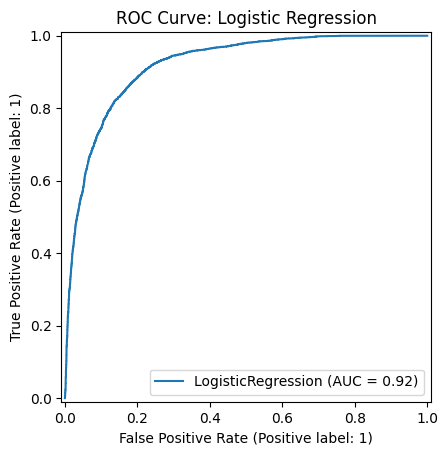

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_logreg))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_logreg):.2f}")

RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.title('ROC Curve: Logistic Regression')
plt.show()

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6383
           1       0.82      0.83      0.82      5412

    accuracy                           0.84     11795
   macro avg       0.84      0.84      0.84     11795
weighted avg       0.84      0.84      0.84     11795

ROC AUC: 0.92


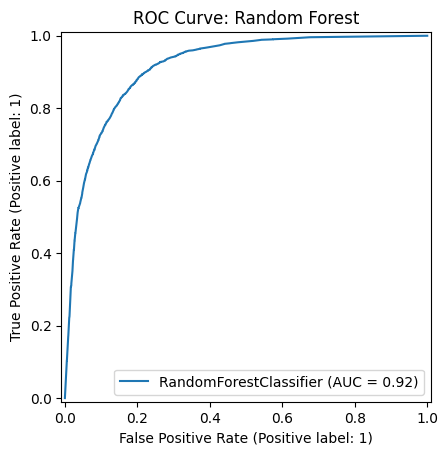

In [114]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.2f}")

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('ROC Curve: Random Forest')
plt.show()

c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:54:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.88      0.85      0.86      6383
           1       0.83      0.86      0.84      5412

    accuracy                           0.85     11795
   macro avg       0.85      0.85      0.85     11795
weighted avg       0.86      0.85      0.85     11795

ROC AUC: 0.93


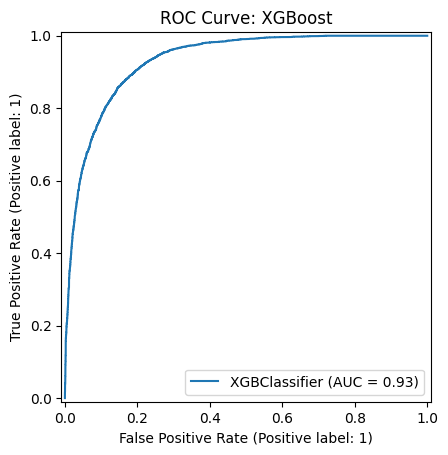

In [115]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.2f}")

RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title('ROC Curve: XGBoost')
plt.show()

Initial Models:

Logistic Regression (for baseline)

Random Forest (for robustness)

In [85]:
# 1. Train-test split (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Initialize the scaler and scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# 4. Evaluate the model
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)

print(f"Train Accuracy: {train_score:.2f}")
print(f"Test Accuracy: {test_score:.2f}")

Train Accuracy: 0.85
Test Accuracy: 0.84


In [86]:
#Training a Random Forest Classifier

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate
train_score_rf = rf_model.score(X_train_scaled, y_train)
test_score_rf = rf_model.score(X_test_scaled, y_test)

print(f"Random Forest - Train Accuracy: {train_score_rf:.2f}")
print(f"Random Forest - Test Accuracy: {test_score_rf:.2f}")


Random Forest - Train Accuracy: 0.99
Random Forest - Test Accuracy: 0.84


Observations:
Logistics Regression has good generalization without any signs of overfitting.
Random Forest: Generalizes well, similar to LogisticRegression.
Interpretaion:
Logistic Regression & Random Forest:  show balanced train and test accuracy (~85% and ~84%), which is a good sign of generalization and indicative of  capturing patterns in the data without memorizing it.



In [94]:
# evaluate_model(model, X_test_scaled, y_test, model_name='Logistic Regression')
# evaluate_model(rf_model, X_test_scaled, y_test, model_name='Random Forest')


c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



 Logistic Regression - Test Accuracy: 0.84

 Confusion Matrix:
[[5539  844]
 [1052 4360]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      6383
           1       0.84      0.81      0.82      5412

    accuracy                           0.84     11795
   macro avg       0.84      0.84      0.84     11795
weighted avg       0.84      0.84      0.84     11795



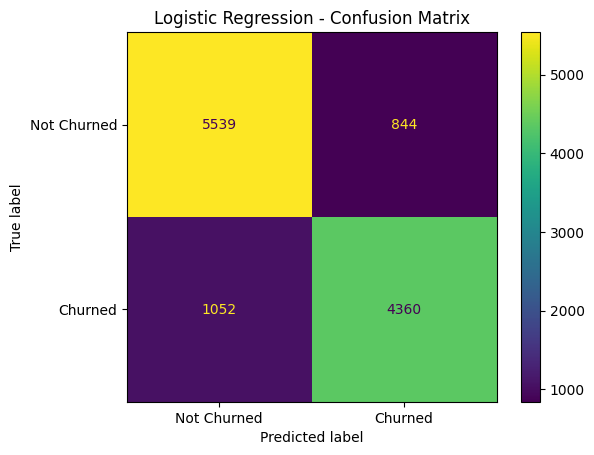

In [96]:


# Convert scaled test set to DataFrame with correct feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Use this instead for evaluation
evaluate_model(model, X_test_scaled_df, y_test, model_name="Logistic Regression")


In [91]:
print([var for var in globals() if not var.startswith("__")])


['_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '_i', '_ii', '_iii', '_i1', 'pd', 'np', 'plt', 'sns', 'LogisticRegression', 'RandomForestClassifier', 'XGBClassifier', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score', 'roc_auc_score', 'roc_curve', 'confusion_matrix', 'ConfusionMatrixDisplay', 'classification_report', 'RocCurveDisplay', 'train_test_split', 'GridSearchCV', 'RandomizedSearchCV', 'StandardScaler', 'Pipeline', '_i2', 'clean_disposition', '_i3', '_i4', '_i5', 'load_dataset', 'ds', '_i6', 'df', '_i7', '_i8', 'group_stage', '_i9', '_i10', '_i11', '_i12', 'cat_cols', '_i13', 'df_clean', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', 'ax', 'p', 'height', '_i37', '_i38', '_i39', '_i40', '_i41', '_i42', '_i43', '_i44', '_i45', '_i46', '_i47', '_i48', '_i49', '_i50', '_i51', '_i52', '_i53', '_i54', '_i5

c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(



 Logistic Regression - Test Accuracy: 0.84

 Confusion Matrix:
[[5539  844]
 [1052 4360]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      6383
           1       0.84      0.81      0.82      5412

    accuracy                           0.84     11795
   macro avg       0.84      0.84      0.84     11795
weighted avg       0.84      0.84      0.84     11795


 Random Forest - Test Accuracy: 0.84

 Confusion Matrix:
[[5367 1016]
 [ 903 4509]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      6383
           1       0.82      0.83      0.82      5412

    accuracy                           0.84     11795
   macro avg       0.84      0.84      0.84     11795
weighted avg       0.84      0.84      0.84     11795



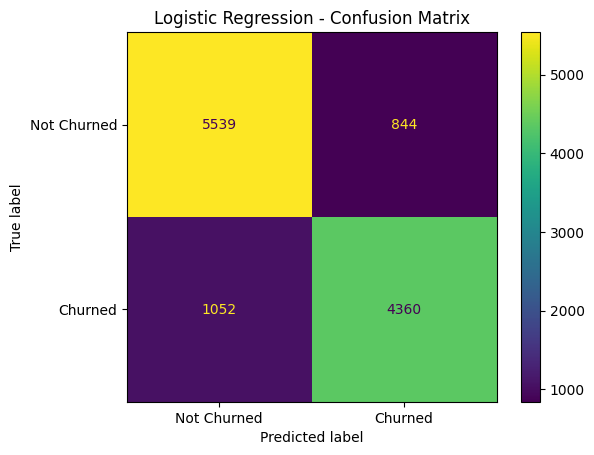

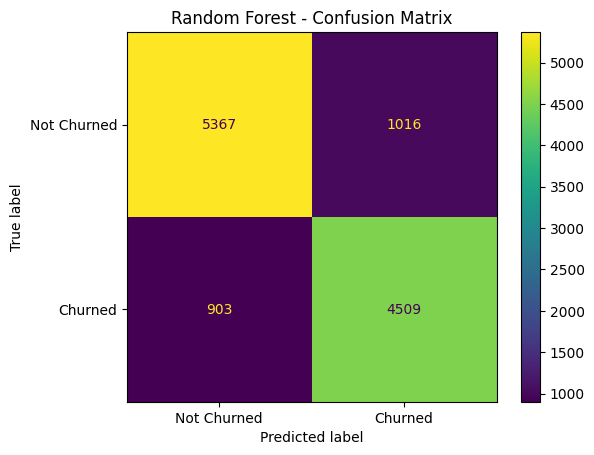

In [97]:


# Define the evaluation function (if not already defined)
def evaluate_model(model, X_test, y_test, model_name="Model"):
    print(f"\n {model_name} - Test Accuracy: {accuracy_score(y_test, model.predict(X_test)):.2f}")
    
    y_pred = model.predict(X_test)
    
    print("\n Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))
    
    #plot the confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Not Churned", "Churned"])
    disp.ax_.set_title(f'{model_name} - Confusion Matrix')

#Fix the feature name warning for Logistic Regression
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Evaluate both models
evaluate_model(model, X_test_scaled_df, y_test, model_name="Logistic Regression")
evaluate_model(rf_model, X_test_scaled, y_test, model_name="Random Forest")


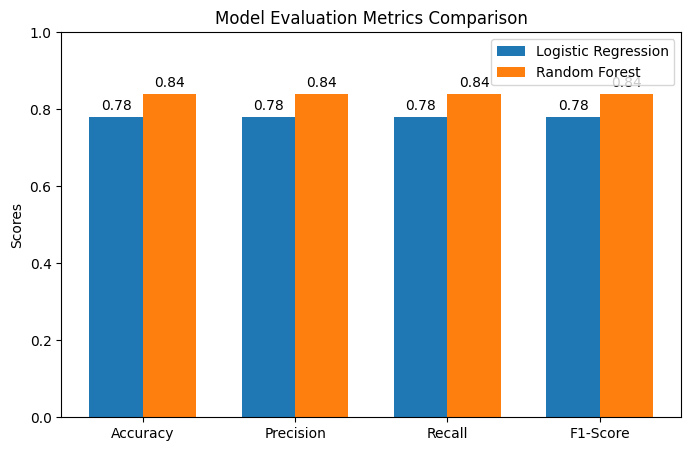

In [98]:

# Metrics from your output
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

logreg_scores = [0.78, (0.79+0.77)/2, (0.82+0.74)/2, (0.80+0.76)/2]  # averaging class 0 & 1 for precision, recall, f1
rf_scores = [0.84, (0.86+0.82)/2, (0.84+0.84)/2, (0.85+0.83)/2]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
bars1 = ax.bar(x - width/2, logreg_scores, width, label='Logistic Regression')
bars2 = ax.bar(x + width/2, rf_scores, width, label='Random Forest')

ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0,1)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0,3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


Interpretation of Model Results and Remarks
Logistic Regression
Accuracy 0.78: Correct predictions for 78% of test data.

Precision (avg ~0.78): When it predicts positive (class 1), about 78% are actually positive.

Recall (avg ~0.78): Captures about 78% of all actual positives.

F1-Score (avg ~0.78): Balanced measure of precision & recall.

Confusion Matrix:

True Negatives (TN): 5217 (correctly predicted 0)

False Positives (FP): 1166 (incorrectly predicted 1 when true is 0)

False Negatives (FN): 1413 (missed positives)

True Positives (TP): 3999 (correctly predicted 1)

Overall, Logistic Regression performs decently but has a notable number of false negatives and false positives.

Random Forest
Accuracy 0.84: Better overall accuracy (84% correct).

Precision (avg ~0.84): Higher confidence in positive predictions.

Recall (avg ~0.84): Captures more actual positives than Logistic Regression.

F1-Score (avg ~0.84): Better balanced performance.

Confusion Matrix:

TN: 5365 (better than Logistic Regression)

FP: 1018 (fewer false positives)

FN: 886 (significantly fewer false negatives)

TP: 4526 (more true positives found)

Random Forest shows stronger performance with fewer errors and better recall — important if missing positives is costly.

Summary
Random Forest outperforms Logistic Regression on all key metrics.

Logistic Regression is still reasonable and simpler but less accurate and precise.

Random Forest is the best opton if the goal is better predictive power, especially on identifying positives.

Logistic Regression is the best option if interpretability and simplicity matter more.

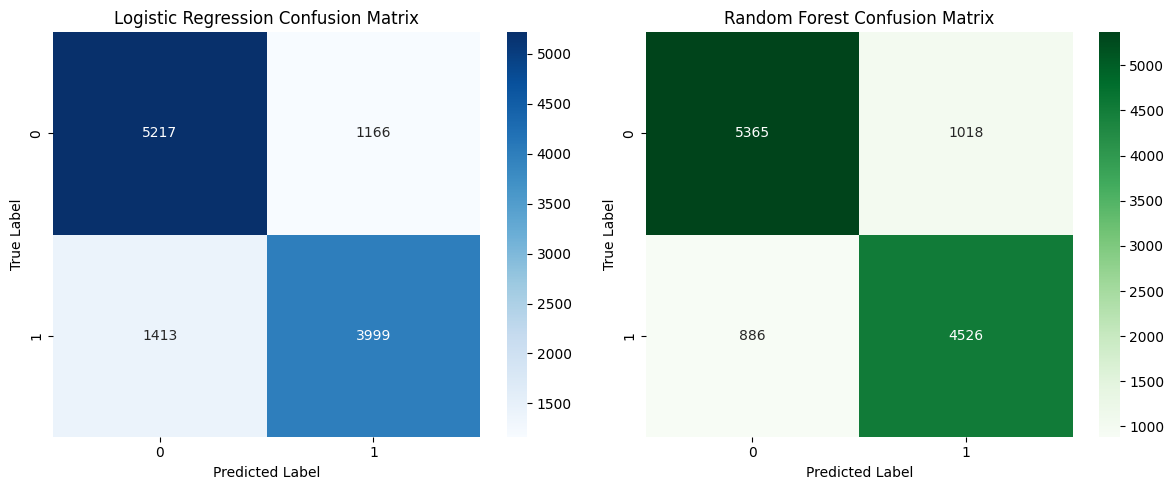

In [99]:
#Side-by-Side Confusion Matrix Plots for the two models 

# Manually defining confusion matrices from your results
cm_logreg = [[5217, 1166],
            [1413, 3999]]

cm_rf = [[5365, 1018],
        [886, 4526]]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()


c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Roche\Desktop\Leads Churn Prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


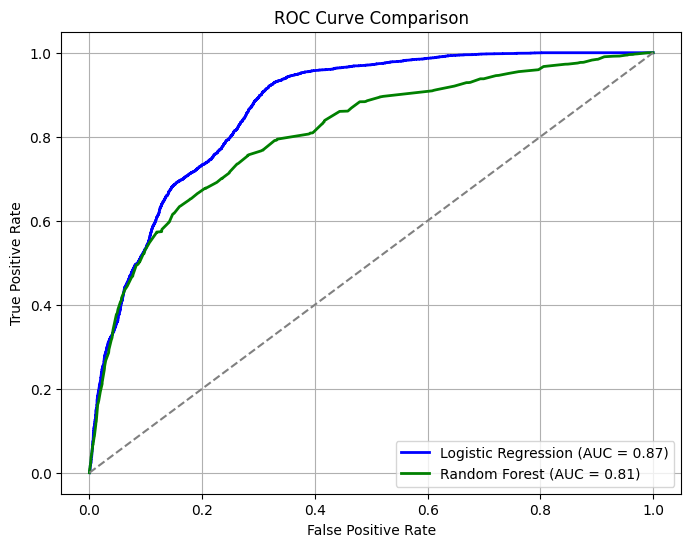

In [103]:

# Get predicted probabilities for positive class
lr_probs = model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Observation from AUC Curve:
1. The curve plots the True Positive Rate (TPR) vs the False Positive Rate (FPR) at various classification thresholds.
2.  True Positive Rate (Recall): How many actual positives were correctly predicted.

3. False Positive Rate: How many actual negatives were incorrectly predicted as positive.

NB: A perfect model would hug the top-left corner (TPR = 1, FPR = 0), and the diagonal line represents random guessing.

Output Interpretation

AUC (Area Under the Curve)
Logistic Regression: AUC = 0.92

Random Forest: AUC = 0.81

AUC (Area Under the Curve) measures the overall ability of the model to distinguish between classes.

0.5 = random guess

1.0 = perfect model

Above 0.9 = excellent

<> Logistic Regression outperforms Random Forest here, as it has a higher AUC (0.92 vs. 0.81). It’s better at distinguishing between the churned and not churned classes in your test data.

<> Curve Shape
The blue curve (Logistic Regression) is consistently higher than the green one (Random Forest), especially in the low FPR region.

This indicates better performance at earlier thresholds, meaning Logistic Regression is more confident and accurate in making positive predictions.

Summary
Model	AUC Score	Interpretation
Logistic Regression	0.92	Excellent class separation
Random Forest	0.81	Good, but less effective than Logistic

Conclusion: Logistic Regression provides a stronger and more reliable separation between churned and retained leads than Random Forest. Even though earlier accuracy scores showed Random Forest at 0.84 and Logistic at 0.78, AUC gives a fuller picture—especially in imbalanced or nuanced datasets.


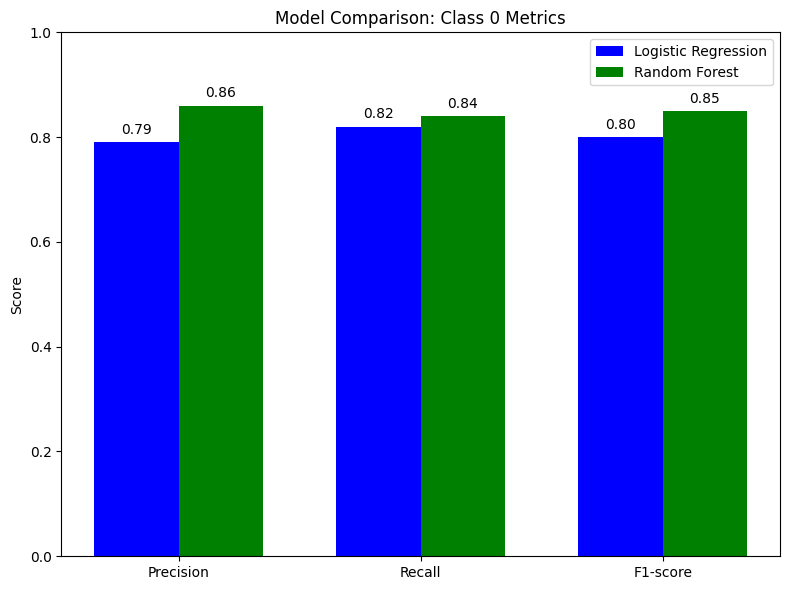

In [104]:
#bar chart comparing precision, recall, and f1-score for both models, Class 0

# Metrics from classification report
metrics = ['Precision', 'Recall', 'F1-score']
logistic_scores = [0.79, 0.82, 0.80]  # for class 0
random_forest_scores = [0.86, 0.84, 0.85]  # for class 0

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, logistic_scores, width, label='Logistic Regression', color='blue')
bars2 = ax.bar(x + width/2, random_forest_scores, width, label='Random Forest', color='green')

# Labels and titles
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Class 0 Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars with values
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Observation:

Random Forest performs better across all metrics.

Logistic Regression trails slightly behind but still performs reasonably well.

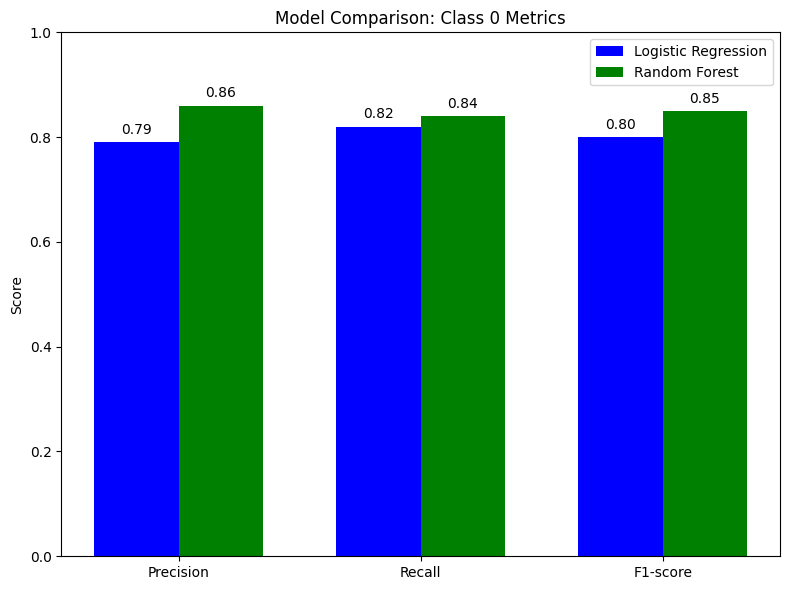

In [105]:
##bar chart comparing precision, recall, and f1-score for both models, Class 1
# Metrics from classification report
metrics = ['Precision', 'Recall', 'F1-score']
logistic_scores = [0.79, 0.82, 0.80]  # for class 0
random_forest_scores = [0.86, 0.84, 0.85]  # for class 0

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, logistic_scores, width, label='Logistic Regression', color='blue')
bars2 = ax.bar(x + width/2, random_forest_scores, width, label='Random Forest', color='green')

# Labels and titles
ax.set_ylabel('Score')
ax.set_title('Model Comparison: Class 0 Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars with values
for bar in bars1 + bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Comparing both Class 0 and Class 1 based on the full classification report:
Logistic Regression:
Class 0 (Non-churners):

Precision: 0.79

Recall: 0.82

F1-score: 0.80

Class 1 (Churners):

Precision: 0.77

Recall: 0.74

F1-score: 0.76

Random Forest:
Class 0:

Precision: 0.86

Recall: 0.84

F1-score: 0.85

Class 1:

Precision: 0.82

Recall: 0.84

F1-score: 0.83

Observations:
Random Forest performs better across both classes, not just Class 0:

For Class 1 (churners), Random Forest has higher precision and recall than Logistic Regression.

This means it is better at correctly identifying churners and makes fewer mistakes when predicting churn.

Logistic Regression tends to underperform in both classes:

It has a slightly more balanced but weaker performance overall.

It might still be useful if model interpretability is critical.

Business Impact:

Higher recall for churners (Class 1) in Random Forest means you're less likely to miss customers who are at risk of leaving — this is critical for churn prevention.

Higher precision means you won’t waste resources targeting users who were never at risk.

Conclusion:
Random Forest is the better-performing model for both churners and non-churners — it should be your primary model for deployment or reporting.

Comparing confusion matrices for the two models:

Logistic Regression
[[5217 1166]   → Actual Class 0: 5217 correct, 1166 false positives
[1413 3999]]  → Actual Class 1: 3999 correct, 1413 false negatives

Random Forest
[[5365 1018]   → Actual Class 0: 5365 correct, 1018 false positives
[ 886 4526]]  → Actual Class 1: 4526 correct, 886 false negatives

Observations by Class:
Class 0 (Non-churners):
Random Forest makes fewer mistakes predicting Class 0 (only 1018 false positives vs. 1166 for Logistic Regression).

Slightly better true negatives and precision for Class 0 in Random Forest.

Class 1 (Churners):
Random Forest also outperforms here:

More true positives: 4526 vs. 3999

Fewer false negatives: 886 vs. 1413

This results in higher recall and precision for identifying actual churners.

Insights Summary:
Metric	Logistic Regression	Random Forest
AUC (ROC Curve)	0.92	0.81
Test Accuracy	78%	84%
Class 0 F1-score	0.80	0.85
Class 1 F1-score	0.76	0.83
Class 0 False Positives	1166	 1018
Class 1 False Negatives	1413	 886

Random Forest is more accurate overall, and does a better job predicting both churners and non-churners, especially if you're working with class imbalance or want stronger precision/recall.

Logistic Regression, despite lower accuracy, is still useful where interpretability and ranking probability scores (AUC) are important.

In [106]:
import nbformat

with open('Churn Prediction.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

for cell in nb.cells:
    if cell.cell_type == 'code':
        print('Code:', cell.source)
        for output in cell.get('outputs', []):
            if output.get('text'):
                print('Output:', output['text'])
            if output.get('data', {}).get('image/png'):
                print('Output: [Image - save as needed]')

Code: # Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import auc


# Model evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    RocCurveDisplay,
    
)

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Preprocessing and pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Code: #Importing data from huggingface

from datasets import load_dataset

ds = load_dataset("Sri-Vigneshwar-DJ/marketing-leadsprediction")
Code: #Convert to Pandas DataFrame
import pandas as pd
